In [1]:
import numpy as np
from pyedflib import highlevel

In [2]:
# В пояснении не нуждается
def generate_out_for_signal(signals, signal_headers, header):
    out = np.zeros((3, signals.shape[1]))

    ds1 = 0
    is1 = 0
    swd1 = 0

    for annotation in header['annotations']:
        if annotation[2] not in ['ds1', 'is1', 'swd1', 'ds2', 'is2', 'swd2', 'dds2']:
            raise Exception('Unknown annotation: ' + annotation[2])

        if annotation[2] == 'ds1':
            time = int(annotation[0] * signal_headers[0]['sample_rate'])
            ds1 = time
        elif annotation[2] == 'is1':
            time = int(annotation[0] * signal_headers[0]['sample_rate'])
            is1 = time
        elif annotation[2] == 'swd1':
            time = int(annotation[0] * signal_headers[0]['sample_rate'])
            swd1 = time
        elif annotation[2] == 'ds2' or annotation[2] == 'dds2':
            time = int(annotation[0] * signal_headers[0]['sample_rate'])
            out[0, ds1:time] = 1
        elif annotation[2] == 'is2':
            time = int(annotation[0] * signal_headers[0]['sample_rate'])
            out[1, is1:time] = 1
        elif annotation[2] == 'swd2':
            time = int(annotation[0] * signal_headers[0]['sample_rate'])
            out[2, swd1:time] = 1
    return out

In [3]:
signals, signal_headers, header = highlevel.read_edf(r'train_dataset_minzdrav_train\ECoG_fully_marked_(4+2 files, 6 h each)\Ati4x1_15m_BL_6h_fully_marked.edf')
signals.shape

(3, 8640400)

In [4]:
signals = signals[:-1]
signals.shape

(2, 8640400)

In [5]:
#Собираем обучалку
mega_signal = np.zeros((3, 0))
mega_out = np.zeros((3, 0))
# H2O вроде бы отравляет данные
for file in ['Ati4x1_15m_BL_6h_fully_marked.edf', #'Ati4x1_15m_H2O_6h_fully_marked.edf', 
             #'Ati4x3_12m_BL_6h_fully_marked.edf',
             'Ati4x6_14m_BL_6h_fully_marked.edf']:
    signals, signal_headers, header = highlevel.read_edf(r'train_dataset_minzdrav_train\ECoG_fully_marked_(4+2 files, 6 h each)\\' + file)
    out = generate_out_for_signal(signals, signal_headers, header)
    mega_signal = np.hstack((mega_signal, signals))
    mega_out = np.hstack((mega_out, out))

signals = mega_signal
out = mega_out

signals.shape, out.shape

((3, 17280800), (3, 17280800))

In [66]:
signals, signal_headers, header = highlevel.read_edf(
    r'train_dataset_minzdrav_train\ECoG_fully_marked_(4+2 files, 6 h each)\Ati4x3_12m_BL_6h_fully_marked.edf'
    )
out = generate_out_for_signal(signals, signal_headers, header)

In [67]:
#header["annotations"]

In [81]:
# Делаем преобразование Фурье и генерит выборку
def fft_conv(signals, out):
    from scipy.fft import fft, fftfreq
    Fs = 400
    window = 50
    threshold = 20
    size = signals.shape[1]
    padding = 10
    n = (size - window) // (window - padding)
    print(n)

    X_fft = np.zeros((n, window))
    _y_fft = np.zeros((n, 3))
    frequencies = fftfreq(window, 1 / Fs)
    buffer = np.concatenate((signals[0], np.zeros(padding)))
    count = 0
    for i in range(0, len(signals[0]), window - padding):
        #print(i)
        fft_sig_0 = fft(buffer[i:i + window]).reshape((1, window))
        if frequencies[np.argmax(np.abs(fft_sig_0))] > 2 and frequencies[np.argmax(np.abs(fft_sig_0))] < threshold:
            #X_fft[i, :] = np.hstack((np.abs(fft_sig_0), np.abs(fft_sig_1)))
            X_fft[count, :] = np.abs(fft_sig_0)
            _y_fft[count, :] = out[:, i]
            count += 1
    '''
    for i in range(n):
        fft_sig_0 = fft(signals[0, i * (window - padding):(i + 1) * (window - padding)]).reshape((1, window))
        #fft_sig_1 = fft(signals[1, i*window:(i+1)*window]).reshape((1, window))
        #fft_sig_2 = fft(signals[2, i*window:(i+1)*window]).reshape((1, window))
        if frequencies[np.argmax(np.abs(fft_sig_0))] > 2 and frequencies[np.argmax(np.abs(fft_sig_0))] < threshold:
            #X_fft[i, :] = np.hstack((np.abs(fft_sig_0), np.abs(fft_sig_1)))
            X_fft[i, :] = np.abs(fft_sig_0)
            _y_fft[i, :] = out[:, i * window]
    '''

    y_fft = np.zeros(n)
    y_fft[:] = _y_fft[:, 0] + _y_fft[:, 1] * 2 + _y_fft[:, 2] * 3

    return X_fft, y_fft

X_fft, y_fft = fft_conv(signals, out)

216008


In [5]:
X_fft.shape

(172808, 50)

In [100]:
candidates = []
window = 50
padding = 10
mean_signal = np.mean(np.abs(signals[0]))
n = signals.shape[1] // window
count_per_window = 0
count = 0
for i in range(0, len(signals[0]), window - padding):
    max_window = np.max(np.mean(np.abs(signals[0, i:i + window])))
    if i * window == int(5.07 * 1e6):
        x = 0
    if max_window / mean_signal > 1.9:
        if np.max(X_fft[count]) > 7 and np.max(X_fft[count]) < 11:
            count_per_window += 1
            if count_per_window > 4:
                #print("huj")
                candidates[len(candidates) - count_per_window:] = [3] * (count_per_window - 1)
                candidates.append(3)
            else:
                candidates.append(0)
        else:
            candidates.append(0)
    else:
        #if count_per_window > 0:
            #print(count_per_window, (400 * 2 / window) / 2)
        count_per_window = 0
        candidates.append(0)
    count += 1

In [95]:
len(candidates), y_fft.shape

(216010, (216008,))

In [101]:
np.sum(candidates) / 3

11.0

In [8]:
out[2].shape

(8640400,)

In [102]:
np.sum(y_fft == 3) / 3

989.0

In [62]:
selected_elements = out[2][int(5.0675 * 1e6)  : int(5.0725* 1e6) + 1]

# Count the number of nonzero elements
nonzero_count = np.count_nonzero(selected_elements)

print("Number of nonzero elements between indices a and b:", nonzero_count)

Number of nonzero elements between indices a and b: 2400


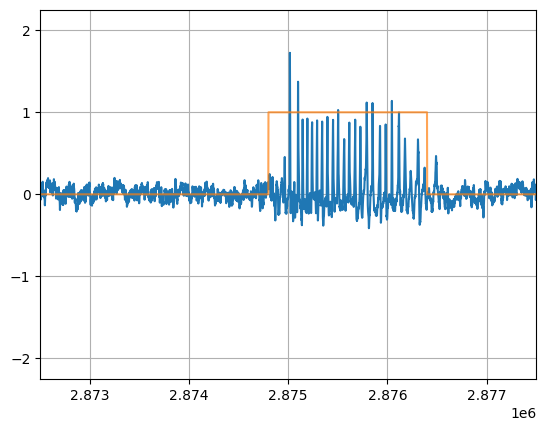

In [58]:
import matplotlib.pyplot as plt

plt.plot(signals[0])
plt.plot(out[2], alpha = .7)
plt.xlim(57450 * 50, 57550 * 50)
plt.grid()
#plt.xticks(np.arange(0, 10_000_000, step=500_000))

plt.show()

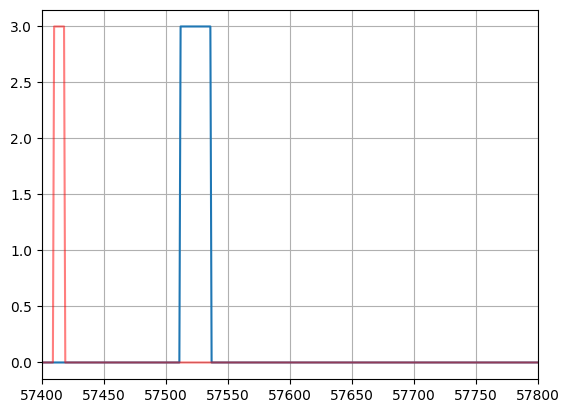

In [82]:
plt.plot((y_fft == 3) * 3)
#plt.xlim(101400 - 10, 101400 + 10)
plt.xlim(57_400, 57_800)
plt.plot(candidates, color = "red", alpha = .5)
plt.grid()
plt.show()

In [7]:
y_fft_r = []

for i in y_fft:
  if i == 0:
    y_fft_r.append([1, 0, 0, 0])
  if i == 1:
    y_fft_r.append([0, 1, 0, 0])
  if i == 2:
    y_fft_r.append([0, 0, 1, 0])
  if i == 3:
    y_fft_r.append([0, 0, 0, 1])

y_fft_r = np.array(y_fft_r)
y_fft_r.shape

(86404, 4)

In [8]:
from imblearn.under_sampling import RandomUnderSampler
# Делаем нормализацию и балансировку
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_fft = scaler.fit_transform(X_fft)
tom = RandomUnderSampler()
X_fft_under, y_fft_under = tom.fit_resample(X_fft, y_fft)

X_train, X_test, y_train, y_test = train_test_split(X_fft_under, y_fft_under, test_size=0.25)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((2022, 400), (674, 400), (2022,), (674,))

# CATBOOST

In [9]:
from catboost import CatBoostClassifier
from sklearn.metrics import classification_report, make_scorer, recall_score
from sklearn.model_selection import RandomizedSearchCV

In [11]:
# Initialize the CatBoost classifier
catboost = CatBoostClassifier(loss_function='MultiClass', task_type="GPU", class_weights="Balanced",
                               verbose=500, depth = 6, learning_rate = .3, iterations = 1000, random_seed=42, #l2_leaf_reg = .3
                               )

#recall_scorer = make_scorer(recall_score, average='macro')

# Perform RandomizedSearchCV
#random_search_catboost = RandomizedSearchCV(estimator=catboost, param_distributions=param_grid, cv=3, n_iter=10, scoring=recall_scorer)

# Fit the model
catboost.fit(X_train, y_train)

0:	learn: 1.0694923	total: 19.4ms	remaining: 19.3s
500:	learn: 0.0114881	total: 5.99s	remaining: 5.96s
999:	learn: 0.0042778	total: 11.9s	remaining: 0us


In [12]:
#Собираем обучалку
mega_signal = np.zeros((3, 0))
mega_out = np.zeros((3, 0))
# H2O вроде бы отравляет данные
for file in ['Ati4x3_12m_BL_6h_fully_marked.edf']:
    signals, signal_headers, header = highlevel.read_edf(r'train_dataset_minzdrav_train\ECoG_fully_marked_(4+2 files, 6 h each)\\' + file)
    out = generate_out_for_signal(signals, signal_headers, header)
    mega_signal = np.hstack((mega_signal, signals))
    mega_out = np.hstack((mega_out, out))

signals = mega_signal
out = mega_out

signals.shape, out.shape

((3, 8640400), (3, 8640400))

In [13]:
X_fft, y_fft = fft_conv(signals, out)
X_fft = scaler.fit_transform(X_fft)
y_fft_r = []

for i in y_fft:
  if i == 0:
    y_fft_r.append([1, 0, 0, 0])
  if i == 1:
    y_fft_r.append([0, 1, 0, 0])
  if i == 2:
    y_fft_r.append([0, 0, 1, 0])
  if i == 3:
    y_fft_r.append([0, 0, 0, 1])

y_fft_r = np.array(y_fft_r)
y_fft_r.shape

(43202, 4)

In [14]:
y_pred = catboost.predict(X_fft)

In [16]:
print(classification_report(y_fft, y_pred))

              precision    recall  f1-score   support

         0.0       1.00      0.70      0.82     38494
         1.0       0.47      0.79      0.59      3717
         2.0       0.03      0.73      0.06       364
         3.0       0.69      0.90      0.78       627

    accuracy                           0.71     43202
   macro avg       0.55      0.78      0.56     43202
weighted avg       0.94      0.71      0.80     43202



# MULTILAYER PERCEPTRON

In [8]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.metrics import recall_score
import matplotlib.pyplot as plt

# Define the model
class FCNN(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        super(FCNN, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, hidden_size)
        self.fc3 = nn.Linear(hidden_size, num_classes)
        self.relu = nn.ReLU()
        self.Drop = nn.Dropout(p=0.3)
    
    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.Drop(x)
        x = self.relu(self.fc2(x))
        x = self.fc3(x)
        return x

# Hyperparameters
input_size = 200  # As per your input shape
hidden_size = 512
num_classes = 4  # Assuming binary classification
learning_rate = 1e-5
num_epochs = 100
batch_size = 64
threshold = 1e-4

In [9]:
# Example data loading
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.long)
y_test_tensor = torch.tensor(y_test, dtype=torch.long)

# Data loaders
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [10]:
device = torch.device('cuda:0') if torch.cuda.is_available else torch.device('cpu')

In [11]:
# Initialize the model, loss function, and optimizer
model = FCNN(input_size, hidden_size, num_classes)
model = model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=learning_rate)

In [12]:
# For tracking metrics
train_losses = []
test_losses = []
train_recalls = []
test_recalls = []

# Training loop
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    all_preds = []
    all_labels = []
    
    for X_batch, y_batch in train_loader:
        X_batch = X_batch.to(device)
        y_batch = y_batch.to(device)
        optimizer.zero_grad()
        outputs = model(X_batch)
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(y_batch.cpu().numpy())
    
    train_loss = running_loss / len(train_loader)
    train_losses.append(train_loss)
    train_recall = recall_score(all_labels, all_preds, average="macro")
    train_recalls.append(train_recall)
    
    # Evaluation
    model.eval()
    running_loss = 0.0
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for X_batch, y_batch in test_loader:
            X_batch = X_batch.to(device)
            y_batch = y_batch.to(device)
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)
            running_loss += loss.item()
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(y_batch.cpu().numpy())
    
    test_loss = running_loss / len(test_loader)
    test_losses.append(test_loss)
    test_recall = recall_score(all_labels, all_preds, average="macro")
    test_recalls.append(test_recall)
    
    print(f"Epoch [{epoch + 1}/{num_epochs}], Train Loss: {train_loss:.4f}, Test Loss: {test_loss:.4f}, Train Recall: {train_recall:.4f}, Test Recall: {test_recall:.4f}")

    if epoch > 1:
        if np.abs(test_losses[-1] - test_losses[-2]) < threshold:
            print("Early stopper")
            break

Epoch [1/100], Train Loss: 0.3386, Test Loss: 0.2315, Train Recall: 0.3755, Test Recall: 0.5559
Epoch [2/100], Train Loss: 0.2234, Test Loss: 0.2083, Train Recall: 0.5206, Test Recall: 0.5795
Epoch [3/100], Train Loss: 0.2114, Test Loss: 0.2019, Train Recall: 0.5495, Test Recall: 0.5800
Epoch [4/100], Train Loss: 0.2063, Test Loss: 0.2006, Train Recall: 0.5583, Test Recall: 0.6001
Epoch [5/100], Train Loss: 0.2030, Test Loss: 0.1978, Train Recall: 0.5685, Test Recall: 0.6026
Epoch [6/100], Train Loss: 0.2010, Test Loss: 0.1960, Train Recall: 0.5740, Test Recall: 0.5924
Epoch [7/100], Train Loss: 0.1992, Test Loss: 0.1951, Train Recall: 0.5760, Test Recall: 0.5972
Epoch [8/100], Train Loss: 0.1980, Test Loss: 0.1945, Train Recall: 0.5791, Test Recall: 0.6058
Epoch [9/100], Train Loss: 0.1966, Test Loss: 0.1935, Train Recall: 0.5838, Test Recall: 0.5980
Epoch [10/100], Train Loss: 0.1956, Test Loss: 0.1929, Train Recall: 0.5842, Test Recall: 0.6009
Epoch [11/100], Train Loss: 0.1945, Tes

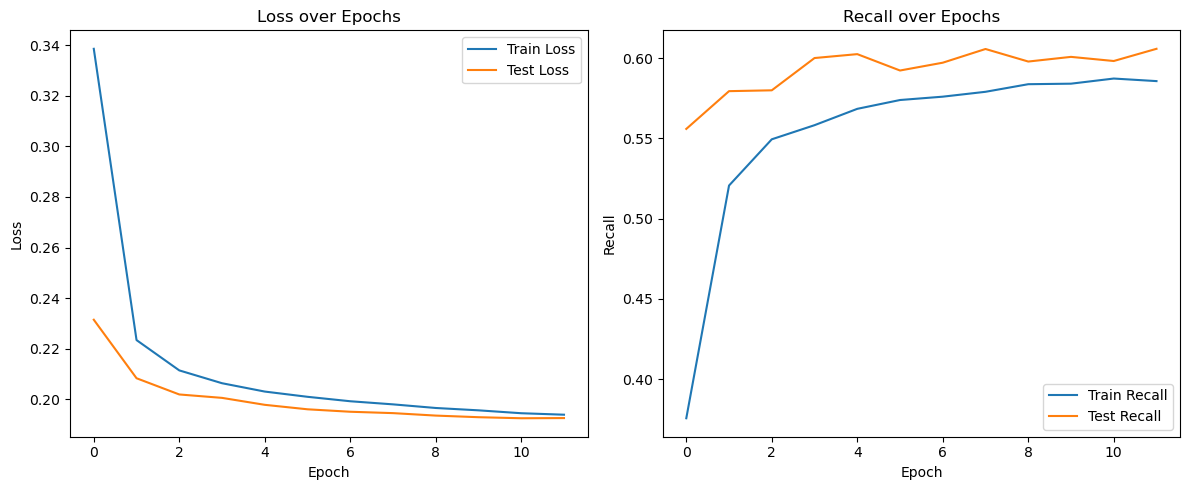

In [13]:
# Plotting loss and recall
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(test_losses, label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Loss over Epochs')

plt.subplot(1, 2, 2)
plt.plot(train_recalls, label='Train Recall')
plt.plot(test_recalls, label='Test Recall')
plt.xlabel('Epoch')
plt.ylabel('Recall')
plt.legend()
plt.title('Recall over Epochs')

plt.tight_layout()
plt.show()

# LOGREG

In [14]:
# Обучаем модель
from sklearn.linear_model import LogisticRegression

model = LogisticRegression(max_iter=1000,
                           solver='saga',
                           penalty= 'elasticnet',
                           l1_ratio= 0.5,
                           class_weight="balanced",
                           n_jobs=-1)
model.fit(X_train, y_train)
model.score(X_test, y_test), model.score(X_train, y_train)

(0.8000709843680076, 0.7996286180166556)

In [15]:
# Смотрим на качество
from sklearn.metrics import classification_report

print(classification_report(y_fft, model.predict(X_fft)))

              precision    recall  f1-score   support

         0.0       0.99      0.82      0.90    224989
         1.0       0.54      0.68      0.60     29360
         2.0       0.03      0.58      0.06      1659
         3.0       0.53      0.80      0.64      3204

    accuracy                           0.80    259212
   macro avg       0.52      0.72      0.55    259212
weighted avg       0.93      0.80      0.85    259212



In [ ]:
# Проверяем на полных файликах
for file in ['Ati4x1_15m_BL_6h_fully_marked.edf', 'Ati4x1_15m_H2O_6h_fully_marked.edf', 
             'Ati4x3_12m_BL_6h_fully_marked.edf', 'Ati4x6_14m_BL_6h_fully_marked.edf']:
    signals, signal_headers, header = highlevel.read_edf(r'train_dataset_minzdrav_train\ECoG_fully_marked_(4+2 files, 6 h each)\\' + file)
    signals = signals[:-1]
    out = generate_out_for_signal(signals, signal_headers, header)
    
    X_fft, y_fft = fft_conv(signals, out)
    s = model.score(X_fft, y_fft)
    print('File:', file, 'Score:', s)
    print(classification_report(y_fft, model.predict(X_fft)))

File: Ati4x1_15m_BL_6h_fully_marked.edf Score: 0.812161474005833
              precision    recall  f1-score   support

         0.0       1.00      0.81      0.89     73411
         1.0       0.44      0.94      0.60     11699
         2.0       0.04      0.10      0.06       860
         3.0       0.02      0.01      0.02       434

    accuracy                           0.81     86404
   macro avg       0.38      0.46      0.39     86404
weighted avg       0.91      0.81      0.84     86404

File: Ati4x1_15m_H2O_6h_fully_marked.edf Score: 0.7138095458543586
              precision    recall  f1-score   support

         0.0       1.00      0.69      0.82     78141
         1.0       0.25      0.94      0.40      8119
         2.0       0.01      0.20      0.03       144
         3.0       0.00      0.00      0.00         0

    accuracy                           0.71     86404
   macro avg       0.32      0.46      0.31     86404
weighted avg       0.93      0.71      0.78     86404

/home/michelangelo/miniconda3/envs/hack/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/michelangelo/miniconda3/envs/hack/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/michelangelo/miniconda3/envs/hack/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


File: Ati4x3_12m_BL_6h_fully_marked.edf Score: 0.6372853108652378
              precision    recall  f1-score   support

         0.0       1.00      0.60      0.75     75953
         1.0       0.22      0.96      0.36      8899
         2.0       0.08      0.12      0.10       458
         3.0       0.62      0.91      0.74      1094

    accuracy                           0.64     86404
   macro avg       0.48      0.65      0.49     86404
weighted avg       0.91      0.64      0.71     86404

File: Ati4x6_14m_BL_6h_fully_marked.edf Score: 0.6570181936021481
              precision    recall  f1-score   support

         0.0       1.00      0.62      0.77     75625
         1.0       0.25      0.95      0.39      8762
         2.0       0.02      0.18      0.04       341
         3.0       0.56      0.93      0.70      1676

    accuracy                           0.66     86404
   macro avg       0.46      0.67      0.47     86404
weighted avg       0.91      0.66      0.72     86404

In [ ]:
# Все данные
mega_signal = np.zeros((3, 0))
mega_out = np.zeros((3, 0))
for file in ['Ati4x1_15m_BL_6h_fully_marked.edf', 'Ati4x1_15m_H2O_6h_fully_marked.edf', 
             'Ati4x3_12m_BL_6h_fully_marked.edf', 'Ati4x6_14m_BL_6h_fully_marked.edf']:
    signals, signal_headers, header = highlevel.read_edf(r'train_dataset_minzdrav_train\ECoG_fully_marked_(4+2 files, 6 h each)\\' + file)
    #signals = signals[:-1]
    out = generate_out_for_signal(signals, signal_headers, header)
    mega_signal = np.hstack((mega_signal, signals))
    mega_out = np.hstack((mega_out, out))

signals = mega_signal
out = mega_out
X_fft, y_fft = fft_conv(signals, out)
X_fft = scaler.fit_transform(X_fft)

In [20]:
model.score(X_fft, y_fft)

0.791517175130781

In [21]:
print(classification_report(y_fft, model.predict(X_fft)))

              precision    recall  f1-score   support

         0.0       0.99      0.81      0.89    303130
         1.0       0.55      0.67      0.60     37479
         2.0       0.02      0.59      0.04      1803
         3.0       0.44      0.80      0.57      3204

    accuracy                           0.79    345616
   macro avg       0.50      0.72      0.53    345616
weighted avg       0.93      0.79      0.85    345616

